In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import util
from util import data_transform, group_calib_feature,sep_err_feature,get_frequencies2, plot_confidence, plot_calib
import pylab
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.tree as tree
import sklearn.neural_network as nn
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


In [2]:
## download "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data" to folder

In [3]:
features = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"] 

original_train = pd.read_csv("adult.data.txt", names=features, sep=r'\s*,\s*', engine='python', na_values="?")
original_test = pd.read_csv("adult.test.txt", names=features, sep=r'\s*,\s*', engine='python', na_values="?", skiprows=1)

num_train = len(original_train)
original = pd.concat([original_train, original_test])
labels = original['Target']
labels = labels.replace('<=50K', 0).replace('>50K', 1)
labels = labels.replace('<=50K.', 0).replace('>50K.', 1)

# Redundant column
del original["Education"]
del original["Target"]

data = data_transform(original)
train_data = data[:num_train]
train_labels = labels[:num_train]
test_data = data[num_train:]
test_labels = labels[num_train:]

In [4]:
len(original_train)

32561

In [5]:
def data_feature_select(df, n_features_to_remove=0, gender=True, seed=0):
    '''Takes a subset of features'''
    # make copy
    data = df.copy()
    
    # remove group info
    if gender:
        #remove gender column
        del data["Sex"]
        col_names = ["Age", "Workclass", "fnlwgt", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Capital Gain", "Capital Loss",
        "Hours per week", "Country"] 
    else:
        #remove race column
        del data["Race"]
        col_names = ["Age", "Workclass", "fnlwgt", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country"] 
    
    # remove n_features_to_remove features to cap model size
    if n_features_to_remove > 0:
        data.drop(col_names[0:(n_features_to_remove)],axis=1,inplace=True)
    
    return data

### Test

In [6]:
cls = linear_model.LogisticRegression()
cls.fit(train_data, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [7]:
predictions = cls.predict(test_data)
scores = cls.predict_proba(test_data)[:, 1]

d = {'target' : test_labels.as_matrix(),
     'score' : scores,
     'prediction' : predictions,
     'race' : original_test['Race'],
     'gender' : original_test['Sex']}
results = pd.DataFrame(data=d)

male = results[results['gender'] == 'Male']
fpr_male, tpr_male, _ = metrics.roc_curve(male['target'], male['score'])
female = results[results['gender'] == 'Female']
fpr_female, tpr_female, _ = metrics.roc_curve(female['target'], female['score'])
white = results[results['race'] == 'White']
fpr_white, tpr_white, _ = metrics.roc_curve(white['target'], white['score'])
black = results[results['race'] == 'Black']
fpr_black, tpr_black, _ = metrics.roc_curve(black['target'], black['score'])

In [8]:
acc = cls.score(test_data,test_labels.as_matrix())
print(acc)

0.8529574350469873


# Different number of training examples vs calibration

In [9]:
def one_learning_curve_expt(df, n_training_examples, gender=True, rm_group=False, return_results=False, seed=0):
    '''Runs an experiment for n_training_examples'''
    if rm_group:
        data = data_feature_select(df, 0, gender)
    else:
        data = df.copy()
    data = data_transform(data)
    
    # random training set of size n_training_examples
    np.random.seed(seed=seed)
    training_indices = np.random.choice(num_train, n_training_examples, replace=False)
    train_data = data.iloc[training_indices]
    train_labels = labels.iloc[training_indices]
    # fixed test set
    test_data = data[num_train:]
    test_labels = labels[num_train:]
        
    cls = linear_model.LogisticRegression()
    cls.fit(train_data, train_labels)
    predictions = cls.predict(test_data)
    scores = cls.predict_proba(test_data)[:, 1]

    d = {'target' : test_labels.as_matrix(),
         'score' : scores,
         'prediction' : predictions,
         'race' : original_test['Race'],
         'gender' : original_test['Sex']}
    results = pd.DataFrame(data=d)
    if gender:
        calib = group_calib_feature(results, 'gender')
        sep = sep_err_feature(results,'gender')
    else:
        calib = group_calib_feature(results, 'race')
        sep = sep_err_feature(results, 'race')
    acc = cls.score(test_data,test_labels.as_matrix())
    score_loss = metrics.log_loss(test_labels.as_matrix(), scores)
    if return_results:
        return calib,sep, acc, score_loss, results
    else:
        return calib,sep, acc, score_loss

In [10]:
repeats = 10
t=30
temp = np.round(np.linspace(10, 2000, t)).astype(int)
temp = np.append(temp, np.round(np.linspace(2000, 10000, t)).astype(int))
t = len(temp)

maxt = 10000
#[mean, std dev]
gender = [np.zeros(t),np.zeros(t)]
race = [np.zeros(t),np.zeros(t)]
acc_g = [np.zeros(t),np.zeros(t)]
acc_r = [np.zeros(t),np.zeros(t)]
res_g = [np.zeros(t),np.zeros(t)]
res_r = [np.zeros(t),np.zeros(t)]
scorel_g = [np.zeros(t),np.zeros(t)]
scorel_r= [np.zeros(t),np.zeros(t)]
sep_g = [np.zeros(t),np.zeros(t)]
sep_r= [np.zeros(t),np.zeros(t)]

In [11]:
for i in range(t):
    temp_a = np.zeros(repeats)
    temp_b = np.zeros(repeats)
    temp_c = np.zeros(repeats)
    temp_d = np.zeros(repeats)
    for j in range(repeats):
        temp_a[j],temp_b[j],temp_c[j],temp_d[j] = one_learning_curve_expt(original,temp[i],gender=True,return_results=False, seed=j)
    gender[0][i] = temp_a.mean()
    sep_g[0][i] = temp_b.mean()
    acc_g[0][i] = temp_c.mean()
    scorel_g[0][i] = temp_d.mean()

    gender[1][i] = temp_a.std()
    sep_g[1][i] = temp_b.std()
    acc_g[1][i] = temp_c.std()
    scorel_g[1][i] = temp_d.std()

In [12]:
for i in range(t):
    temp_a = np.zeros(repeats)
    temp_b = np.zeros(repeats)
    temp_c = np.zeros(repeats)
    temp_d = np.zeros(repeats)
    for j in range(repeats):
        temp_a[j],temp_b[j],temp_c[j],temp_d[j] = one_learning_curve_expt(original,temp[i],gender=False,return_results=False, seed=j)
    race[0][i] = temp_a.mean()
    sep_r[0][i] = temp_b.mean()
    acc_r[0][i] = temp_c.mean()
    scorel_r[0][i] = temp_d.mean()

    race[1][i] = temp_a.std()
    sep_r[1][i] = temp_b.std()
    acc_r[1][i] = temp_c.std()
    scorel_r[1][i] = temp_d.std()   

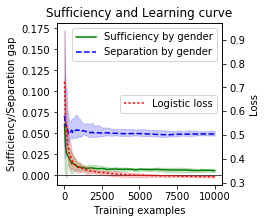

In [13]:
s = 2
fig, ax1 = plt.subplots(1, 1, figsize=(3.8, 3.2))
ax1.set_title('Sufficiency and Learning curve') 
ax1.plot(temp, gender[0], color='g', label='Sufficiency by gender')
ax1.fill_between(temp, gender[0]+s*gender[1], gender[0]-s*gender[1], alpha=.2, color='g')
ax1.plot(temp, sep_g[0], color='b', label='Separation by gender',linestyle="--")
ax1.fill_between(temp, sep_g[0]+s*sep_g[1], sep_g[0]-sep_g[1], alpha=.2, color='b')
ax1.set_ylabel('Sufficiency/Separation gap')
ax1.set_xlabel('Training examples')
ax1.axhline(y=0, color='k', linewidth=.7)
ax1.legend(loc=1)
ax2 = ax1.twinx()
ax2.plot(temp,scorel_g[0],color='r', label='Logistic loss' ,linestyle=':')
ax2.fill_between(temp,scorel_g[0]+s*scorel_g[1], scorel_g[0]-s*scorel_g[1],color='r',alpha=.2 )
ax2.set_ylabel('Loss')
ax2.legend(loc=7, bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('../figures/adult_sepcalibration_gender_learningcurve_loss_errbar_maxn%d.svg'%maxt)
plt.savefig('../figures/adult_sepcalibration_gender_learningcurve_loss_errbar_maxn%d.pdf'%maxt)
plt.show()
plt.gcf().clear() 
plt.close()

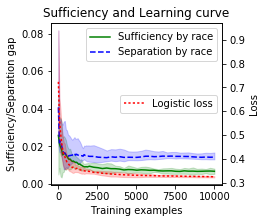

In [14]:
fig, ax1 = plt.subplots(1, 1, figsize=(3.8, 3.2))
ax1.set_title('Sufficiency and Learning curve') 
ax1.plot(temp, race[0], color='g', label='Sufficiency by race')
ax1.fill_between(temp, race[0]+s*race[1], race[0]-s*race[1], alpha=.2, color='g')
ax1.plot(temp, sep_r[0], color='b', label='Separation by race',linestyle="--")
ax1.fill_between(temp, sep_r[0]+s*sep_r[1], sep_r[0]-sep_r[1], alpha=.2, color='b')
ax1.set_ylabel('Sufficiency/Separation gap')
ax1.set_xlabel('Training examples')
ax1.axhline(y=0, color='k', linewidth=.7)
ax1.legend(loc=1)
ax2 = ax1.twinx()
ax2.plot(temp,scorel_r[0],color='r', label='Logistic loss' , linestyle=':')
ax2.fill_between(temp,scorel_r[0]+s*scorel_r[1], scorel_r[0]-s*scorel_r[1],color='r',alpha=.2 )
ax2.set_ylabel('Loss')
ax2.legend(loc=7, bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('../figures/adult_sepcalibration_race_learningcurve_loss_errbar_maxn%d.svg'%maxt)
plt.savefig('../figures/adult_sepcalibration_race_learningcurve_loss_errbar_maxn%d.pdf'%maxt)
plt.show()
plt.gcf().clear() 
plt.close()

# Different number of features vs calibration vs prediction error

In [15]:
def one_feature_expt(df, n_features_to_remove, gender=True, seed=0, return_results=True):
    '''Runs an experiment by removing n_features_to_remove features from dataset'''
    data = data_feature_select(df, n_features_to_remove, gender, seed=seed)
    data = data_transform(data)
    
    # random training set of size n_training_examples
    np.random.seed(seed=seed)
    training_indices = np.random.choice(len(df), num_train, replace=False)
    train_data = data.iloc[training_indices]
    train_labels = labels.iloc[training_indices]
    # fixed test set
    test_indices = ~data.index.isin(training_indices.tolist())
    test_data = data[test_indices]
    test_labels = labels[test_indices]
    
    cls = linear_model.LogisticRegression()
    cls.fit(train_data, train_labels)
    predictions = cls.predict(test_data)
    scores = cls.predict_proba(test_data)[:, 1]
    
    temp = df[test_indices]
    d = {'target' : test_labels.as_matrix(),
         'score' : scores,
         'prediction' : predictions,
         'race' : temp['Race'],
         'gender' : temp['Sex']}
    results = pd.DataFrame(data=d)
    if gender:
        calib = group_calib_feature(results, 'gender')
    else:
        calib = group_calib_feature(results, 'race')
    acc = cls.score(test_data,test_labels.as_matrix())
    score_loss = metrics.log_loss(test_labels.as_matrix(), scores)
    if return_results:
        return calib,acc,score_loss, results
    else:
        return calib,acc,score_loss

### with err bars

In [16]:
t=10
num_features = range(t)
repeats = 20
#[mean, std dev]
gender = [np.zeros(t),np.zeros(t)]
race = [np.zeros(t),np.zeros(t)]
acc_g = [np.zeros(t),np.zeros(t)]
acc_r = [np.zeros(t),np.zeros(t)]
res_g = [np.zeros(t),np.zeros(t)]
res_r = [np.zeros(t),np.zeros(t)]
scorel_g = [np.zeros(t),np.zeros(t)]
scorel_r= [np.zeros(t),np.zeros(t)]
for i in range(t):
    temp_a = np.zeros(repeats)
    temp_b = np.zeros(repeats)
    temp_c = np.zeros(repeats)
    for j in range(repeats):
        temp_a[j],temp_b[j],temp_c[j] = one_feature_expt(original,i,gender=True,return_results=False, seed=j)
    gender[0][i] = temp_a.mean()
    acc_g[0][i] = temp_b.mean()
    scorel_g[0][i] = temp_c.mean()

    gender[1][i] = temp_a.std()
    acc_g[1][i] = temp_b.std()
    scorel_g[1][i] = temp_c.std()


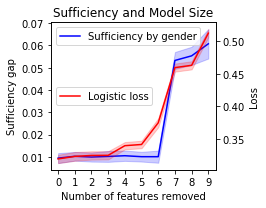

In [17]:
s=2
fig, ax1 = plt.subplots(1, 1, figsize=(3.8, 3))
ax1.set_title('Sufficiency and Model Size') 
ax1.plot(num_features, gender[0], color='b', label='Sufficiency by gender')
ax1.fill_between(num_features, gender[0]+s*gender[1], gender[0]-s*gender[1], alpha=.2, color='b')
ax1.set_ylabel('Sufficiency gap')
ax1.set_xlabel('Number of features removed')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(num_features,scorel_g[0],color='r', label='Logistic loss' )
ax2.fill_between(num_features,scorel_g[0]+s*scorel_g[1], scorel_g[0]-s*scorel_g[1],color='r',alpha=.2 )
ax2.set_ylabel('Loss')
ax2.legend(loc=6)
plt.tight_layout()
plt.savefig('../figures/adult_calibration_gender_modelsize_loss_ebar.svg')
plt.savefig('../figures/adult_calibration_gender_modelsize_loss_ebar.pdf')
plt.show()
plt.gcf().clear() 
plt.close()

In [18]:
for i in range(t):
    temp_a = np.zeros(repeats)
    temp_b = np.zeros(repeats)
    temp_c = np.zeros(repeats)
    for j in range(repeats):
        temp_a[j],temp_b[j],temp_c[j] = one_feature_expt(original,i,gender=False,return_results=False, seed=j)
    race[0][i] = temp_a.mean()
    acc_r[0][i] = temp_b.mean()
    scorel_r[0][i] = temp_c.mean()

    race[1][i] = temp_a.std()
    acc_r[1][i] = temp_b.std()
    scorel_r[1][i] = temp_c.std()   


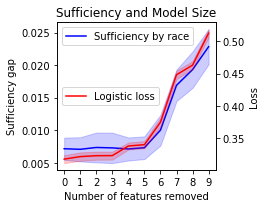

In [19]:
s=2
fig, ax1 = plt.subplots(1, 1, figsize=(3.8, 3))
ax1.set_title('Sufficiency and Model Size') 
ax1.plot(num_features, race[0], color='b', label='Sufficiency by race')
ax1.fill_between(num_features, race[0]+s*race[1], race[0]-s*race[1], alpha=.2, color='b')
ax1.set_ylabel('Sufficiency gap')
ax1.set_xlabel('Number of features removed')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(num_features,scorel_r[0],color='r', label='Logistic loss' )
ax2.fill_between(num_features,scorel_r[0]+s*scorel_r[1], scorel_r[0]-s*scorel_r[1],color='r',alpha=.2 )
ax2.set_ylabel('Loss')
ax2.legend(loc=6)
plt.tight_layout()
plt.savefig('../figures/adult_calibration_race_modelsize_loss_ebar.svg')
plt.savefig('../figures/adult_calibration_race_modelsize_loss_ebar.pdf')
plt.show()
plt.gcf().clear() 
plt.close()

# Different regularization vs calibration vs prediction error

In [20]:
def one_reg_expt(df, reg=1.0, l1=False, seed=0, return_results=True):
    '''Runs an experiment with regularization parameter'''
    if l1==True:
        cls = linear_model.LogisticRegression(penalty='l1',C=reg)
    else:
        cls = linear_model.LogisticRegression(penalty='l2',C=reg)
        
    # random training set of size 
    np.random.seed(seed=seed)
    training_indices = np.random.choice(len(df), num_train, replace=False)
    train_data = data.iloc[training_indices]
    train_labels = labels.iloc[training_indices]
    # fixed test set
    test_indices = ~data.index.isin(training_indices.tolist())
    test_data = data[test_indices]
    test_labels = labels[test_indices]

    cls.fit(train_data, train_labels)
    predictions = cls.predict(test_data)
    scores = cls.predict_proba(test_data)[:, 1]
    
    temp = df[test_indices]
    d = {'target' : test_labels.as_matrix(),
         'score' : scores,
         'prediction' : predictions,
         'race' : temp['Race'],
         'gender' : temp['Sex']}
    results = pd.DataFrame(data=d)
    gender_calib = group_calib_feature(results, 'gender')
    race_calib = group_calib_feature(results, 'race')
    acc = cls.score(test_data,test_labels.as_matrix())
    score_loss = metrics.log_loss(test_labels.as_matrix(), scores)
    if return_results:
        return gender_calib,race_calib,acc, score_loss, results
    else:
        return gender_calib,race_calib,acc, score_loss

In [21]:
temp2 = [ -9, -8, -7, -6, -5, -4, -2, -1, 0]
t = len(temp2)
repeats = 10

reg_param = np.exp(np.array(temp2))
gender2 = [np.zeros(t),np.zeros(t)]
race2 = [np.zeros(t),np.zeros(t)]
scorel =[np.zeros(t),np.zeros(t)]
for i in range(t):
    temp = np.zeros((4, repeats))
    for j in range(repeats):
        temp[0,j],temp[1,j],temp[2,j],temp[3,j] = one_reg_expt(original,reg_param[i],l1=True,return_results=False, seed=j)
        #print(temp[:,j])
    gender2[0][i] = temp[0].mean()
    race2[0][i] = temp[1].mean()
    scorel[0][i] = temp[3].mean()
    
    gender2[1][i] = temp[0].std()
    race2[1][i] = temp[1].std()
    scorel[1][i] = temp[3].std() 

KeyboardInterrupt: 

In [ ]:
s=2
fig, ax1 = plt.subplots(1, 1, figsize=(3.8, 3))
ax1.set_title('Sufficiency and L1 Regularization') 
ax1.plot(temp2, race2[0], color='b', label='Sufficiency by race')
ax1.fill_between(temp2, race2[0]+s*race2[1], race2[0]-s*race2[1], alpha=.2, color='b')
ax1.plot(temp2, gender2[0], color='g', label='Sufficiency by gender')
ax1.fill_between(temp2, gender2[0]+s*gender2[1], gender2[0]-s*gender2[1], alpha=.2, color='g')
ax1.set_ylabel('Sufficiency gap')
ax1.set_xlabel('Regularization parameter (power of 10)')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.legend(loc=1)
ax2 = ax1.twinx()
ax2.plot(temp2,scorel[0],color='r', label='Logistic loss' )
ax2.fill_between(temp2, scorel[0]+s*scorel[1], scorel[0]-s*scorel[1], alpha=.2, color='r')
ax2.set_ylabel('Loss')
ax2.legend(loc=7)
plt.tight_layout()
plt.savefig('../figures/adult_calibration_genderrace_l1_loss_errbar.svg')
plt.savefig('../figures/adult_calibration_race_l1_loss_errbar.pdf')
plt.show()
plt.gcf().clear() 
plt.close()

# Calibration quantile plots of logistic regression models

### regress without group

In [ ]:
races = ['White', 'Black', 'Both']
styles = ['-', '--', ':']
colors = ['g', 'b', 'r']
deciles = range(1, 10+1)
pylab.rc('font',  size='17')
pylab.rc('axes', labelsize='large')
pylab.rc('lines', linewidth=3)

In [ ]:
_,_,_,marginals=one_feature_expt(original,0,False) #race

plot_calib(marginals,"race",title_string="Calibration without group", use_quantiles=False)


In [ ]:
genders = ['Female', 'Male']
_,_,_,marginals = one_feature_expt(original,0,True) #gender

plot_calib(marginals,"gender",title_string="Calibration without group", use_quantiles=False)



### regress with group

In [ ]:
races = ['White', 'Black', 'Both']
styles = ['-', '--', ':']
colors = ['g', 'b', 'r']
deciles = range(1, 10+1)
pylab.rc('font',  size='17')
pylab.rc('axes', labelsize='large')
pylab.rc('lines', linewidth=3)

In [ ]:
_,_,_,_,marginals=one_reg_expt(original) #race
plot_calib(marginals,"race",title_string="Calibration without group", use_quantiles=False)


In [ ]:
genders = ['Female', 'Male']

plot_calib(marginals,"gender",title_string="Calibration without group", use_quantiles=False)



# Multiple group calibration

In [ ]:
# train logistic regression model, compute calibration error for all the features.
cls = linear_model.LogisticRegression()
cls.fit(train_data, train_labels)
predictions = cls.predict(test_data)
scores = cls.predict_proba(test_data)[:, 1]

d = {'target' : test_labels.as_matrix(),
     'score' : scores,
     'prediction' : predictions}

features = ["Age", "Workclass",  "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country"]
for feat in features:
    d[feat] = original_test[feat]
results = pd.DataFrame(data=d)



In [ ]:
def plot_calib_comb(d,feat1_w, feat1, feat2_w, feat2, u, l):
    '''Calibration plot for linear combinations of features'''
    comb_feat = "%.1f*%s+%.1f*%s"%(feat1_w, feat1, feat2_w, feat2)
    d[comb_feat] = feat1_w*original_test[feat1] + feat2_w*original_test[feat2]
    results = pd.DataFrame(data=d)
    results.loc[results[comb_feat] > u, comb_feat] = '>%d'%u
    results.loc[(results[comb_feat] <= u) & (results[comb_feat] > l), comb_feat] = '%d<, <=%d'%(l,u)
    results.loc[results[comb_feat] <= l, comb_feat] = '<=%d'%l
    plot_calib(results, comb_feat,num_to_plot=3, string='logistic_%s'%comb_feat, title_string=comb_feat )

In [ ]:
# combinations of two features
feat1='Age'
feat1_w = 0.6
feat2='Education-Num'
feat2_w = 0.4
u,l=35, 30
plot_calib_comb(d,feat1_w, feat1, feat2_w, feat2, u, l)
plot_calib_comb(d, .3, "Hours per week", 0.7, "Age",50,35)
plot_calib_comb(d, .3, "Capital Gain", -1, "Capital Loss",1000,500)


In [ ]:
feat1='Sex'
feat2='Race'
comb_feat = "%s+%s"%( feat1, feat2)
d[comb_feat] = original_test[feat1] +'+'+ original_test[feat2] 
results = pd.DataFrame(data=d)
plot_calib(results, comb_feat,num_to_plot=4, string='logistic_%s'%comb_feat, title_string=comb_feat )

In [ ]:
# fix age and education num
results2 = results.copy()
results2.loc[results2['Age'] > 40, 'Age'] = '>40'
results2.loc[results2['Age'] <= 40, 'Age'] = '<=40'
results2.loc[results2['Education-Num'] > 10, 'Education-Num'] = '>10'
results2.loc[results2['Education-Num'] <= 10, 'Education-Num'] = '<=10'
results2.loc[results2['Capital Gain'] > 1000, 'Capital Gain'] = '>1000'
results2.loc[results2['Capital Gain'] <= 1000, 'Capital Gain'] = '<=1000'
results2.loc[results2['Capital Loss'] > 1000, 'Capital Loss'] = '>1000'
results2.loc[results2['Capital Loss'] <= 1000, 'Capital Loss'] = '<=1000'
results2.loc[results2['Hours per week'] > 50, 'Hours per week'] = '>50'
results2.loc[results2['Hours per week'] <= 50, 'Hours per week'] = '<=50'

In [ ]:
for feat in features:
    plot_calib(results2, feat,num_to_plot=3, string='logistic_%s'%feat, title_string="Calibration for %s"%feat)